In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import networkx as nx
from itertools import combinations

###############################################################################
# GLOBAL PARAMETERS
###############################################################################
L = 1.0
RC = 0.25 * L  # Communication radius
RS = 0.2 * L   # Sensing radius

# Original 25 node coordinates
orig_points = np.array([
    [0.437, 0.526],
    [0.433, 0.378],
    [0.248, 0.674],
    [0.646, 0.513],
    [0.203, 0.585],
    [0.267, 0.914],
    [0.858, 0.125],
    [0.775, 0.755],
    [0.537, 0.328],
    [0.89,  0.929],
    [0.887, 0.814],
    [0.14,  0.352],
    [0.094, 0.61 ],
    [0.765, 0.936],
    [0.485, 0.824],
    [0.41,  0.0  ],
    [0.105, 0.718],
    [0.5,   0.653],
    [0.942, 0.35 ],
    [0.638, 0.228],
    [0.392, 0.258],
    [0.681, 0.328],
    [0.142, 0.498],
    [0.517, 0.438],
    [0.284, 0.219]
])

###############################################################################
# UTILITY FUNCTIONS
###############################################################################
def compute_connectivity_edges(points, RC):
    """
    Returns a list of edges (i, j) for all pairs of nodes i, j in 'points'
    that lie within distance RC of each other.
    """
    edge_list = []
    for i, j in combinations(range(len(points)), 2):
        dist = np.linalg.norm(points[i] - points[j])
        if dist <= RC:
            edge_list.append((i, j))
    return edge_list

def ensure_full_connectivity(points, RC):
    """
    Iteratively add bridging nodes if the network is not fully connected.
    Each iteration, we connect the first two components by adding a new node
    at the midpoint of their closest pair of nodes.
    """
    points_list = list(points)
    iteration = 0
    
    while True:
        # Build a connectivity graph
        G = nx.Graph()
        for i, p in enumerate(points_list):
            G.add_node(i, pos=p)
        for i, j in combinations(range(len(points_list)), 2):
            if np.linalg.norm(np.array(points_list[i]) - np.array(points_list[j])) <= RC:
                G.add_edge(i, j)
        
        components = list(nx.connected_components(G))
        if len(components) <= 1:
            break  # fully connected
        
        iteration += 1
        # Connect the first two components with a bridging node
        compA = list(components[0])
        compB = list(components[1])
        best_dist = float('inf')
        best_pair = None
        for i in compA:
            for j in compB:
                d = np.linalg.norm(np.array(points_list[i]) - np.array(points_list[j]))
                if d < best_dist:
                    best_dist = d
                    best_pair = (i, j)
        
        pA = np.array(points_list[best_pair[0]])
        pB = np.array(points_list[best_pair[1]])
        bridging_node = (pA + pB) / 2.0
        points_list.append(bridging_node)
        
        print(f"Iteration {iteration}: Added bridging node at {bridging_node.tolist()} "
              f"to connect components {components[0]} and {components[1]}")
    
    return np.array(points_list)

###############################################################################
# PLOTTING FUNCTIONS
###############################################################################
def plot_fully_connected_wsn(points, edge_list):
    """
    Fig. 1. Fully connected original WSN: 
    Red lines for edges, red circles for nodes (no fill).
    """
    fig, ax = plt.subplots(figsize=(8,6))
    # Plot edges (red lines)
    for (i, j) in edge_list:
        ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]],
                color='red', linewidth=1)
    # Plot nodes (red circles, no fill)
    ax.plot(points[:,0], points[:,1], 'o', color='red', markerfacecolor='none',
            markersize=10, markeredgewidth=2, label='Nodes')
    
    ax.set_title('Fig. 1. Fully connected original WSN', fontsize=14)
    ax.set_xlabel('x coordinate (L)')
    ax.set_ylabel('y coordinate (L)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_coverage_wsn(points, edge_list, RS, title='Fig. 2. Coverage of all 25 original nodes'):
    """
    Plots coverage circles (semi-transparent green) + red dashed edges + blue nodes.
    """
    fig, ax = plt.subplots(figsize=(8,6))
    # Coverage circles
    for p in points:
        circle = plt.Circle((p[0], p[1]), RS, color='green', alpha=0.3)
        ax.add_patch(circle)
    # Edges (red dashed)
    for (i, j) in edge_list:
        ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]],
                'r--', alpha=0.5, linewidth=1)
    # Nodes in blue
    ax.plot(points[:,0], points[:,1], 'o', color='blue', markersize=8, label='Nodes')
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('x coordinate (L)')
    ax.set_ylabel('y coordinate (L)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_voronoi_with_breach(points, breach_coords=None):
    """
    Fig. 4. Voronoi tessellation of the updated WSN with a placeholder (or real) breach path in red.
    If 'breach_coords' is given as an Mx2 array, we plot that path in red.
    """
    vor = Voronoi(points)
    fig, ax = plt.subplots(figsize=(8,6))
    # Basic Voronoi plot
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_width=1.5, line_alpha=0.8,
                    point_size=0, line_colors='k')
    # Plot nodes in blue
    ax.plot(points[:,0], points[:,1], 'o', color='blue', markersize=6, label='Nodes')
    
    # Placeholder breach path
    if breach_coords is not None and len(breach_coords) > 1:
        ax.plot(breach_coords[:,0], breach_coords[:,1], 'r-', linewidth=3, label='Maximal Breach Path')
    
    ax.set_title('Fig. 4. Voronoi Tessellation and maximal breach path', fontsize=14)
    ax.set_xlabel('x coordinate (L)')
    ax.set_ylabel('y coordinate (L)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_delaunay_with_support(points, path_indices=None):
    """
    Fig. 5. Delaunay triangulation with a computed maximal support path in red.
    'path_indices' should be the list of node indices in the support path order.
    """
    tri = Delaunay(points)
    fig, ax = plt.subplots(figsize=(8,6))
    # Delaunay edges in black
    ax.triplot(points[:,0], points[:,1], tri.simplices, color='black', linestyle='-', linewidth=1)
    # Nodes in black
    ax.plot(points[:,0], points[:,1], 'o', color='black', markersize=6, label='Nodes')
    
    # If we have a path
    if path_indices is not None and len(path_indices) > 1:
        path_pts = points[path_indices]
        ax.plot(path_pts[:,0], path_pts[:,1], 'r-', linewidth=3, label='Maximal Support Path')
        # Mark start/end in red
        ax.scatter(path_pts[0,0], path_pts[0,1], color='red', s=100, zorder=5, label='Start')
        ax.scatter(path_pts[-1,0], path_pts[-1,1], color='red', s=100, zorder=5, label='End')
    
    ax.set_title('Fig. 5. Delaunay triangulation and the maximal support path', fontsize=14)
    ax.set_xlabel('x coordinate (L)')
    ax.set_ylabel('y coordinate (L)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return tri

###############################################################################
# MAXIMAL SUPPORT PATH (Actual Computation)
###############################################################################
def compute_maximal_support_path(points):
    """
    Builds a graph from the Delaunay edges, with cost = half the edge length.
    Returns a list of node indices for the minimal-cost path from the node 
    nearest (0,0) to the node nearest (1,1).
    """
    tri = Delaunay(points)
    # Build graph
    G_del = nx.Graph()
    for i in range(len(points)):
        G_del.add_node(i, pos=points[i])
    for simplex in tri.simplices:
        for k in range(3):
            m = (k+1) % 3
            idxA = simplex[k]
            idxB = simplex[m]
            d = np.linalg.norm(points[idxA] - points[idxB])
            if not G_del.has_edge(idxA, idxB):
                G_del.add_edge(idxA, idxB, weight=d/2.0)
    
    # Start/end
    start = np.argmin(np.linalg.norm(points - np.array([0,0]), axis=1))
    end   = np.argmin(np.linalg.norm(points - np.array([1,1]), axis=1))
    
    try:
        path_indices = nx.shortest_path(G_del, source=start, target=end, weight='weight')
        return path_indices
    except nx.NetworkXNoPath:
        print("No path found between (0,0) and (1,1).")
        return None

###############################################################################
# MAIN
###############################################################################
def main():
    # 1) Original edges
    orig_edge_list = compute_connectivity_edges(orig_points, RC)
    # Fig. 1: Fully connected original WSN
    plot_fully_connected_wsn(orig_points, orig_edge_list)
    
    # Fig. 2: Coverage of the original WSN
    plot_coverage_wsn(orig_points, orig_edge_list, RS, 
                      title='Fig. 2. Coverage of all 25 original nodes')
    
    # 2) Ensure full connectivity by iterative bridging
    full_points = ensure_full_connectivity(orig_points, RC)
    # Recompute edges for updated network
    updated_edge_list = compute_connectivity_edges(full_points, RC)
    
    # Fig. 3: Updated network’s full connectivity + coverage
    plot_coverage_wsn(full_points, updated_edge_list, RS,
                      title='Fig. 3. Updated network’s full connectivity and coverage')
    
    # 3) Voronoi + placeholder maximal breach path
    # If you have real breach path coords, supply them here as an Nx2 array.
    # For now, let's just define a dummy line from (0,0) to (1,1).
    # Replace with your actual breach path logic if implemented.
    dummy_breach_path = np.array([[0,0],[0.1,0.2],[0.4,0.4],[0.7,0.6],[1,1]])
    plot_voronoi_with_breach(full_points, breach_coords=dummy_breach_path)
    
    # 4) Delaunay + actual maximal support path
    support_path_indices = compute_maximal_support_path(full_points)
    plot_delaunay_with_support(full_points, path_indices=support_path_indices)

if __name__ == "__main__":
    main()


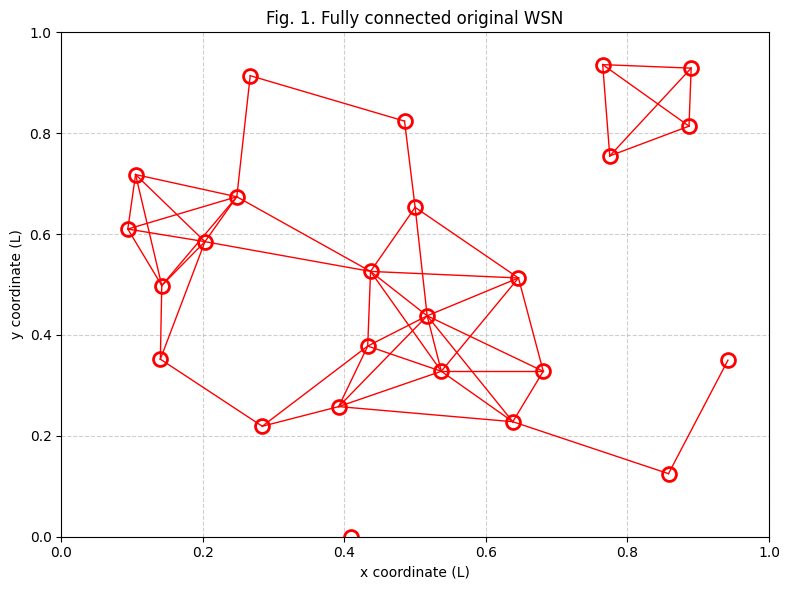

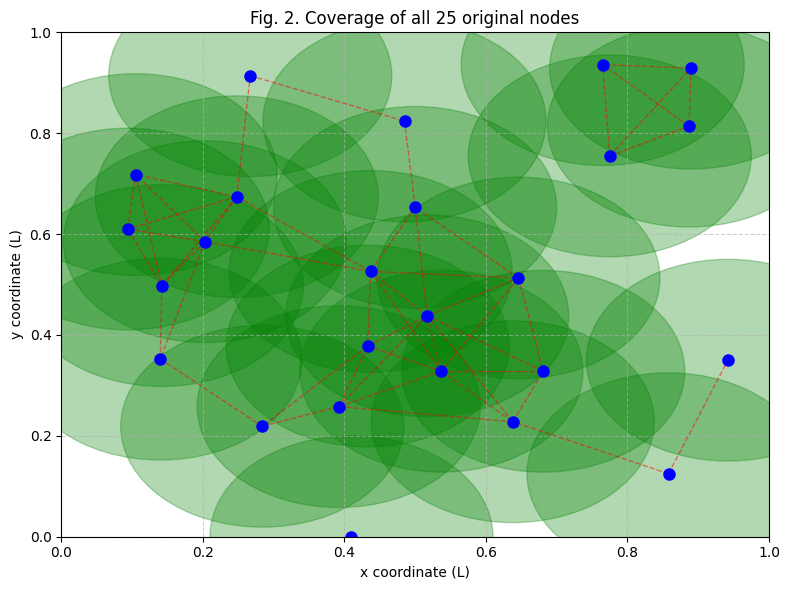

Iteration 1 Added bridging node at [0.7105, 0.634]
Iteration 2 Added bridging node at [0.347, 0.1095]


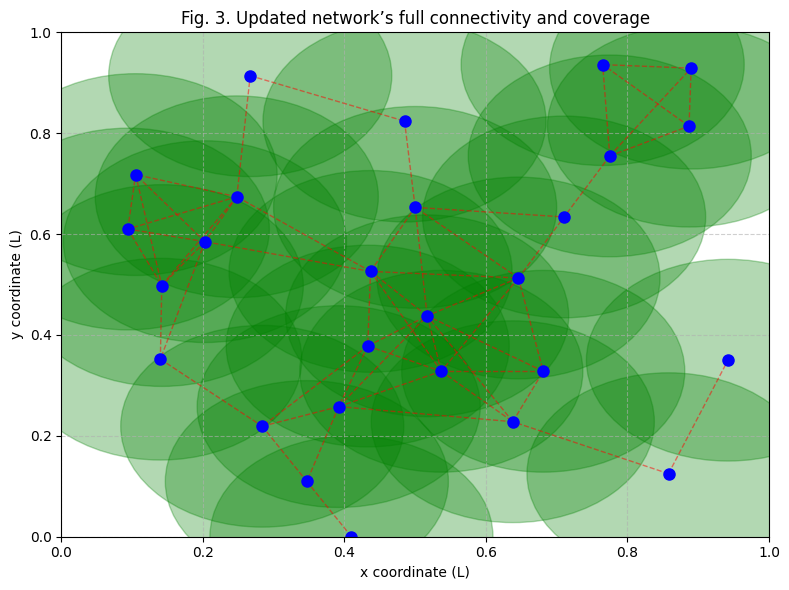

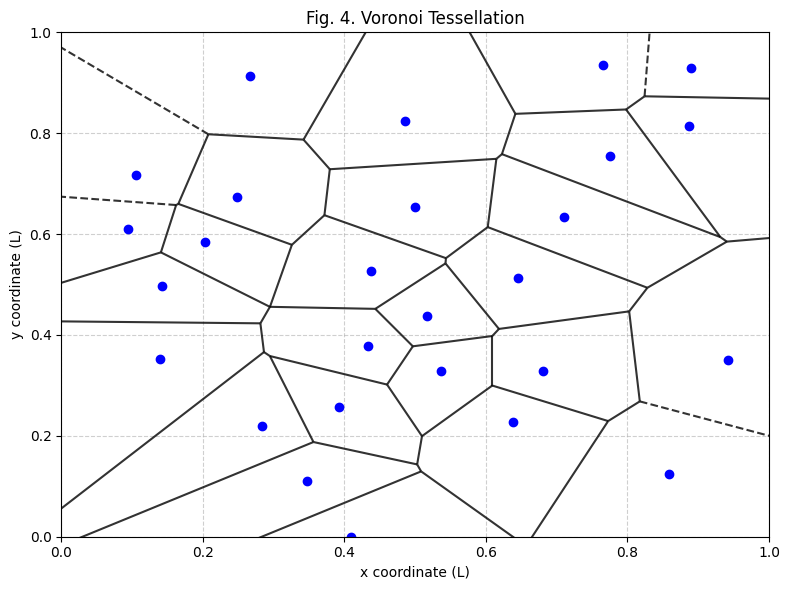

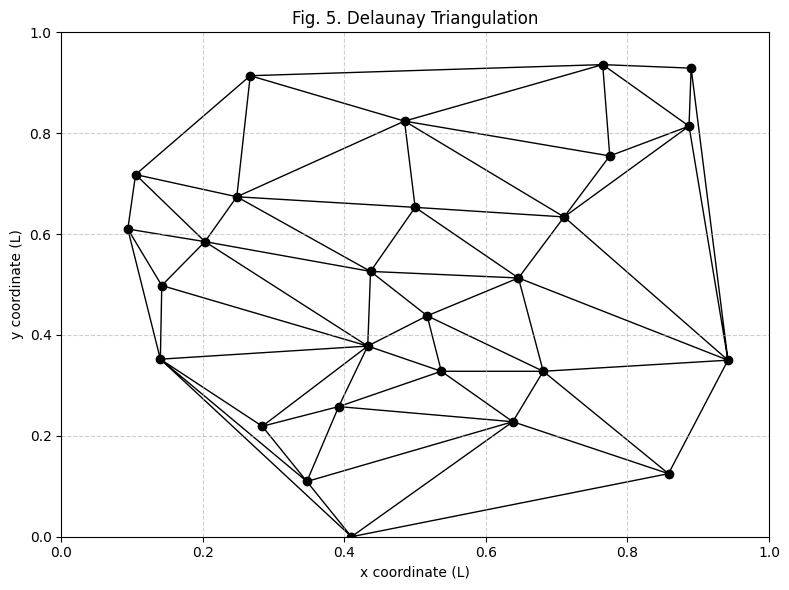

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import networkx as nx
from itertools import combinations

L = 1.0
RC = 0.25 * L
RS = 0.2 * L

orig_points = np.array([
    [0.437, 0.526],
    [0.433, 0.378],
    [0.248, 0.674],
    [0.646, 0.513],
    [0.203, 0.585],
    [0.267, 0.914],
    [0.858, 0.125],
    [0.775, 0.755],
    [0.537, 0.328],
    [0.89,  0.929],
    [0.887, 0.814],
    [0.14,  0.352],
    [0.094, 0.61 ],
    [0.765, 0.936],
    [0.485, 0.824],
    [0.41,  0.0  ],
    [0.105, 0.718],
    [0.5,   0.653],
    [0.942, 0.35 ],
    [0.638, 0.228],
    [0.392, 0.258],
    [0.681, 0.328],
    [0.142, 0.498],
    [0.517, 0.438],
    [0.284, 0.219]
])

def compute_connectivity_edges(points, RC):
    edge_list = []
    for i, j in combinations(range(len(points)), 2):
        d = np.linalg.norm(points[i] - points[j])
        if d <= RC:
            edge_list.append((i, j))
    return edge_list

def ensure_full_connectivity(points, RC):
    pts = list(points)
    iteration = 0
    while True:
        G = nx.Graph()
        for i, p in enumerate(pts):
            G.add_node(i, pos=p)
        for i, j in combinations(range(len(pts)), 2):
            if np.linalg.norm(np.array(pts[i]) - np.array(pts[j])) <= RC:
                G.add_edge(i, j)
        comps = list(nx.connected_components(G))
        if len(comps) <= 1:
            break
        iteration += 1
        cA = list(comps[0])
        cB = list(comps[1])
        best_d = float('inf')
        best_pair = None
        for i in cA:
            for j in cB:
                d = np.linalg.norm(np.array(pts[i]) - np.array(pts[j]))
                if d < best_d:
                    best_d = d
                    best_pair = (i, j)
        pA = np.array(pts[best_pair[0]])
        pB = np.array(pts[best_pair[1]])
        mid = (pA + pB) / 2
        pts.append(mid)
        print("Iteration", iteration, "Added bridging node at", mid.tolist())
    return np.array(pts)

def plot_fully_connected_wsn(points, edge_list):
    fig, ax = plt.subplots(figsize=(8,6))
    for (i, j) in edge_list:
        ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], color='red', linewidth=1)
    ax.plot(points[:,0], points[:,1], 'o', color='red', markerfacecolor='none', markersize=10, markeredgewidth=2)
    ax.set_title("Fig. 1. Fully connected original WSN")
    ax.set_xlabel("x coordinate (L)")
    ax.set_ylabel("y coordinate (L)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_coverage_wsn(points, edge_list, RS, title):
    fig, ax = plt.subplots(figsize=(8,6))
    for p in points:
        circle = plt.Circle((p[0], p[1]), RS, color='green', alpha=0.3)
        ax.add_patch(circle)
    for (i, j) in edge_list:
        ax.plot([points[i,0], points[j,0]], [points[i,1], points[j,1]], 'r--', alpha=0.5, linewidth=1)
    ax.plot(points[:,0], points[:,1], 'o', color='blue', markersize=8)
    ax.set_title(title)
    ax.set_xlabel("x coordinate (L)")
    ax.set_ylabel("y coordinate (L)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_voronoi_with_breach(points):
    vor = Voronoi(points)
    fig, ax = plt.subplots(figsize=(8,6))
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_width=1.5, line_alpha=0.8, point_size=0, line_colors='k')
    ax.plot(points[:,0], points[:,1], 'o', color='blue', markersize=6)
    ax.set_title("Fig. 4. Voronoi Tessellation")
    ax.set_xlabel("x coordinate (L)")
    ax.set_ylabel("y coordinate (L)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_delaunay_with_support(points):
    tri = Delaunay(points)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.triplot(points[:,0], points[:,1], tri.simplices, color='black', linestyle='-', linewidth=1)
    ax.plot(points[:,0], points[:,1], 'o', color='black', markersize=6)
    ax.set_title("Fig. 5. Delaunay Triangulation")
    ax.set_xlabel("x coordinate (L)")
    ax.set_ylabel("y coordinate (L)")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def compute_maximal_support_path(points):
    tri = Delaunay(points)
    G_del = nx.Graph()
    for i in range(len(points)):
        G_del.add_node(i)
    for s in tri.simplices:
        for k in range(3):
            m = (k+1) % 3
            A = s[k]
            B = s[m]
            d = np.linalg.norm(points[A] - points[B])
            if not G_del.has_edge(A, B):
                G_del.add_edge(A, B, weight=d/2)
    start = np.argmin(np.linalg.norm(points - np.array([0,0]), axis=1))
    end   = np.argmin(np.linalg.norm(points - np.array([1,1]), axis=1))
    try:
        path_indices = nx.shortest_path(G_del, source=start, target=end, weight='weight')
        return path_indices
    except nx.NetworkXNoPath:
        return None

def main():
    orig_edges = compute_connectivity_edges(orig_points, RC)
    plot_fully_connected_wsn(orig_points, orig_edges)
    plot_coverage_wsn(orig_points, orig_edges, RS, "Fig. 2. Coverage of all 25 original nodes")
    full_pts = ensure_full_connectivity(orig_points, RC)
    upd_edges = compute_connectivity_edges(full_pts, RC)
    plot_coverage_wsn(full_pts, upd_edges, RS, "Fig. 3. Updated network’s full connectivity and coverage")
    plot_voronoi_with_breach(full_pts)
    compute_maximal_support_path(full_pts)
    plot_delaunay_with_support(full_pts)

if __name__ == "__main__":
    main()
